In [1]:
import sys
sys.path.append('..')
import ugent

In [2]:
from schrodinger import Schrodinger2D, Rectangle
import numpy as np

s = Schrodinger2D(lambda x, y: x**2 + y**2, Rectangle(-9.5,9.5, -9.5,9.5),
                  gridSize=(75,75), maxBasisSize=60)


s.eigenvalues(21, shiftInvert=False, ncv=100)[:21]

[1.9999999999999587,
 3.9999999999968363,
 4.000000000000134,
 5.999999999997876,
 5.999999999999107,
 6.0000000000005596,
 7.999999999997561,
 7.999999999998423,
 8.000000000000476,
 8.000000000000725,
 9.99999999999848,
 9.999999999998487,
 9.999999999999604,
 9.999999999999963,
 10.000000000000266,
 11.999999999998378,
 11.999999999998883,
 11.999999999999071,
 11.999999999999138,
 12.000000000000114,
 12.000000000000114]

In [15]:
from p_tqdm import p_map

    
def test_problem(settings):
    exact = settings["exact"]
        
    def single_solve(params):
        n, m = params
        fds = Schrodinger2D(settings['V'], Rectangle(*settings['domain']), gridSize=(n,n), maxBasisSize=m)
        return params, np.abs((fds.eigenvalues(len(exact), sparse=True, shiftInvert=False, ncv=min(n*n, 4*len(exact))) - exact)/exact)

    parameters = settings["parameters"]
    results = dict(p_map(single_solve, parameters))
    
    results_by_n = {}
    results_by_m = {}
    for (n,m), r in results.items():
        if n not in results_by_n:
            results_by_n[n] = {}
        if m not in results_by_m:
            results_by_m[m] = {}

        results_by_n[n][m] = r
        results_by_m[m][n] = r
    
    return results_by_n, results_by_m

In [16]:
import math

settings = {
    "exact": np.array([2*i for i in range(1, 30) for k in range(i)][:100]),
    "multiplicities": [i for i in range(1, 30)],
    "V": lambda x, y:  x*x + y*y,
    "domain": (-9.5, 9.5, -9.5, 9.5),
    "parameters": [
        (n, m) for n in [20, 30, 40, 50, 60, 70] for m in [16, 32, 48, 64] if m // 16 <= math.ceil(n / 16)
    ]
}

results_by_n, results_by_m = test_problem(settings)

  0%|          | 0/19 [00:00<?, ?it/s]

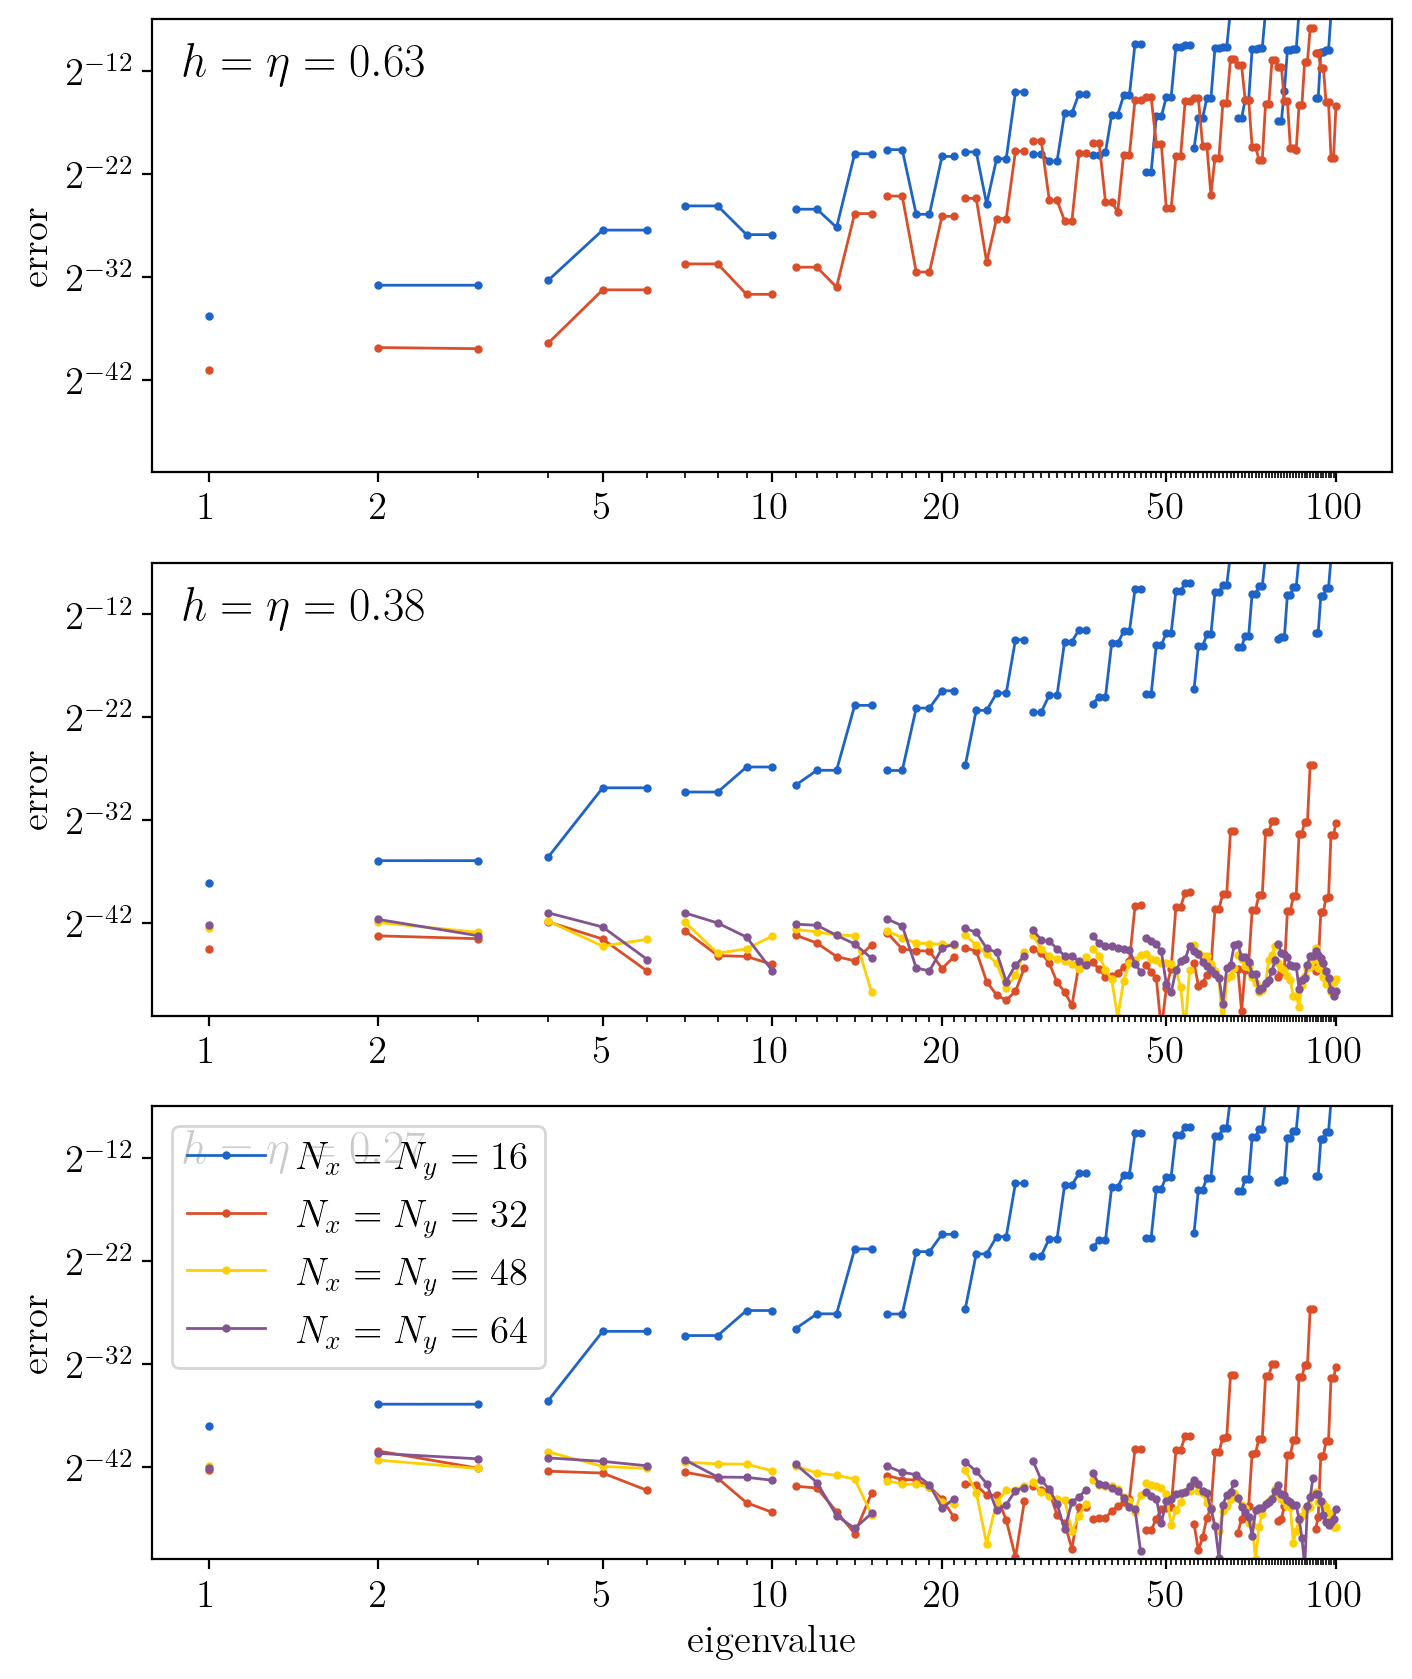

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FormatStrFormatter, ScalarFormatter


fig, axes = plt.subplots(3, 1, figsize=(8, 10), dpi=200)
    
for ni, n in enumerate([30, 50, 70]):
    rm = results_by_n[n]
    N = len(next(iter(rm.values())))

    ax = axes[ni]
    ax.set_xscale('log', base=10)
    ax.set_yscale('log', base=2)
    ax.xaxis.set_major_locator(FixedLocator([1, 2, 5, 10, 20, 50, 100]))
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.set_minor_locator(FixedLocator(range(1, N)))
    ax.xaxis.set_minor_formatter(FormatStrFormatter(""))
    ax.set_ylim(2**-51, 2**-7)
    ax.set_ylabel("error")
    if ni == 2:
        ax.set_xlabel("eigenvalue")

    mults = settings["multiplicities"]

    for i, (m, r) in enumerate(sorted(rm.items())):
        j = 0

        kwargs = dict(
            label=f"$N_x=N_y={m}$",
            color=ugent.palet[i],
            marker='.', ls='-', lw=1, markersize=4,
        )
        for mult in mults:
            d = r[j:j+mult]
            ax.plot(range(j + 1, j+len(d)+1), d, **kwargs)
            if j == 0:
                del kwargs["label"]
            j += mult
            if j >= len(r):
                break

    ax.set_title(f"$h = \\eta = {19/n:.2f}$", y=0.835, x=0.025, loc="left")
    if ni == 2:
        ax.legend()
fig.show()
plt.savefig(f"nm_test_harmonic.pdf", bbox_inches="tight")